In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from socialbehavior.models.hmm import HMM
from socialbehavior.observations.ar_gaussian_observation import ARGaussianObservation
from socialbehavior.transformations.linear import LinearTransformation
from socialbehavior.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
import sys
import time

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj29 = rendered_data[29]

/Users/leah/miniconda2/envs/ptc/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/leah/miniconda2/envs/ptc/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/leah/miniconda2/envs/ptc/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [15]:
K = 5
D = 4
T = 36000

tran = LinearTransformation(K=K, d_in=D, d_out=D)
observation = ARGaussianObservation(K=K, D=D, M=0, transformation=tran)

model = HMM(K=K, D=D, M=0, observation=observation)

data = torch.tensor(traj29, dtype=torch.float64)

In [16]:
model.log_likelihood(data)

tensor(-51096492.5848, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

In [17]:
num_iters = 5000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.0001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

In [55]:
# another 5000
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

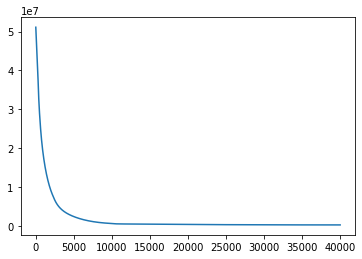

In [56]:
plt.plot(losses)

In [60]:
z = model.most_likely_states(data)

In [61]:
sample_z, sample_x = model.sample(T)

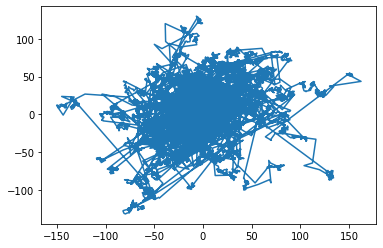

In [62]:
plt.plot(sample_x[:,0].numpy(), sample_x[:,1].numpy())

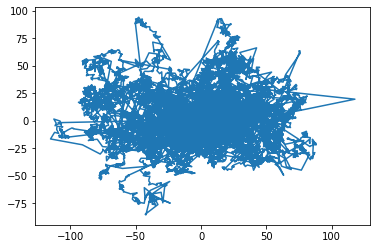

In [63]:
plt.plot(sample_x[:,2].numpy(), sample_x[:,3].numpy())

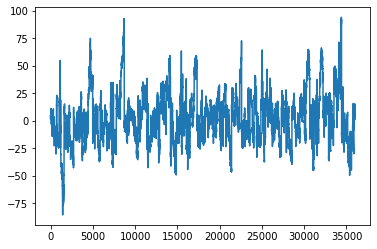

In [64]:
plt.plot(sample_x[:,3].numpy())

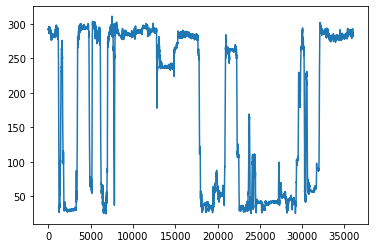

In [47]:
plt.plot(data[:,0].numpy())

In [57]:
x_predict_arr = k_step_prediction(model, z, data)

In [58]:
x_predict_arr.shape

(36000, 4)

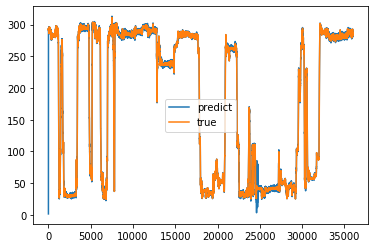

In [59]:
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

In [ ]:
# condition on z_sequence and the first observation, predict the following observations
